In [17]:
import os
import os.path as osp
import time
import json
import imageio
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import plotly.graph_objects as go
import matplotlib.animation as animation
import matplotlib.patches as patches

from radar_dataclass import *
from natsort import natsorted
from radar_data_preprocess import RadarData
from typing import List, Dict
from mpl_toolkits.mplot3d import Axes3D


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

warnings.filterwarnings('ignore')

In [18]:
RADAR_DATA_DIR = '../radar/json/'

start_time = time.time()

data = RadarData(root_path=RADAR_DATA_DIR, duration_frames=10)

print(time.time() - start_time)

Loading raw RADAR frames...:  40%|████      | 4/10 [00:00<00:00, 10.12it/s]


KeyboardInterrupt: 

In [ ]:
frame_dict: Dict[int, Radar] = data.frame_dict
frame_info_list: List[frameHeader] = [frame_dict[keys].frameInfo for keys in frame_dict]

dets_list: List[detections] = [frame_dict[keys].dets for keys in frame_dict]
trks_list: List[tracks] = [frame_dict[keys].trks for keys in frame_dict]

In [ ]:
len(dets_list[0].det_list)

141

In [ ]:
# frame_time_list = list()

# for frame_info in frame_info_list:
#     frame_time_list.append(frame_info.add_frameTime_ms)

# plt.plot(range(len(frame_time_list)), frame_time_list)
# plt.grid(linestyle='--')

In [ ]:
# frame_diff_time_list = list()
# frame_ref_time = frame_info_list[0].add_frameTime_ms

# for frame_info in frame_info_list[1:]:
#     frame_diff_time_list.append(frame_info.add_frameTime_ms - frame_ref_time)
#     frame_ref_time = frame_info.add_frameTime_ms

# plt.plot(range(len(frame_diff_time_list)), frame_diff_time_list)
# plt.grid(linestyle='--')

In [ ]:
# sns.distplot(frame_diff_time_list, bins=100)
# plt.xlabel('Time interval (ms)')
# plt.savefig('Time interval density.svg', format='svg')

In [ ]:
det_nums_list = list()

for det_frame in dets_list:
    det_nums_list.append(len(det_frame.dets))

plt.figure(figsize=(100,3))
plt.plot(range(len(det_nums_list)), det_nums_list)
plt.grid(linestyle='--')

AttributeError: 'detPointsStruct' object has no attribute 'dets'

In [ ]:
# plt.scatter(frame_diff_time_list, det_nums_list[1:])

In [ ]:
# trk_nums_list = list()

# for frame_info in frame_info_list:
#     trk_nums_list.append(frame_info.numTracker)

# plt.figure(figsize=(100,3))
# plt.plot(range(len(trk_nums_list)), trk_nums_list)
# plt.grid(linestyle='--')

In [ ]:
# plt.scatter(frame_diff_time_list, trk_nums_list[1:])

In [ ]:
# fig = go.Figure(data=[go.Scatter3d(
#     x=frame_diff_time_list,
#     y=trk_nums_list[1:],
#     z=det_nums_list[1:],
#     mode='markers',  # 'lines', 'markers', 'lines+markers'
#     marker=dict(
#         size=1,
#         color=det_nums_list[1:],    
#         colorscale='Viridis',
#         opacity=1
#     )
# )])

# fig.update_layout(
#     scene=dict(
#         xaxis_title='X Axis',
#         yaxis_title='Y Axis',
#         zaxis_title='Z Axis'
#     ),
# )

MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x169a4a670> (for post_execute):


AttributeError: 'NoneType' object has no attribute 'trks'

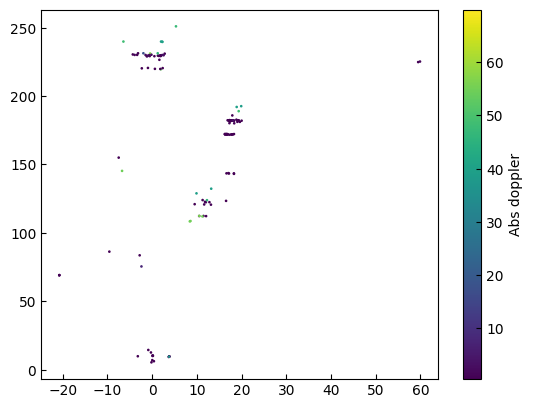

In [ ]:
# frame_idx = 1


# import matplotlib.animation as animation

# fig, ax = plt.subplots()
# # cmap = plt.get_cmap('viridis')
# # norm = plt.Normalize(vmin=min([item.doppler for det_frame in dets_list for item in det_frame.dets]), vmax=max([item.doppler for det_frame in dets_list for item in det_frame.dets]))

# def update(frame_idx):
#     ax.clear()
#     single_frame_dets_array = np.array([np.array([item.add_pos_x, item.add_pos_y, item.doppler]) for item in dets_list[frame_idx].dets])

#     ax.scatter(single_frame_dets_array[:, 1], single_frame_dets_array[:, 0], s=0.8, )
#     ax.set_title(f'Frame {frame_idx}')
#     ax.set_xlim(-100, 100)
#     ax.set_ylim(-10, 500)
#     ax.grid(True)

# ani = animation.FuncAnimation(fig, update, frames=len(dets_list), repeat=False)
# ani.save('radar_animation.gif', writer='imagemagick')


fig, ax = plt.subplots()

doppler_all_frames = []

for frame_idx in range(len(dets_list)):
    single_frame_dets_array = np.array([np.array([item.add_pos_x, item.add_pos_y, item.doppler]) for item in dets_list[frame_idx].det_list])
    doppler_all_frames.extend(np.abs(single_frame_dets_array[:, 2]))

doppler_min = min(doppler_all_frames)
doppler_max = max(doppler_all_frames)

cmap = 'viridis'
scatter = ax.scatter([], [], c=[], s=10, cmap=cmap, vmin=doppler_min, vmax=doppler_max)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Abs doppler')

def update(frame_idx):
    ax.clear()
    
    single_frame_dets_array = np.array([np.array([item.add_pos_x, item.add_pos_y, item.doppler]) for item in dets_list[frame_idx].det_list])
    doppler_vals = single_frame_dets_array[:, 2] 

    for coll in ax.collections:
        coll.remove()
    
    scatter = ax.scatter(single_frame_dets_array[:, 1], single_frame_dets_array[:, 0], c=doppler_vals, s=0.8, cmap=cmap, vmin=doppler_min, vmax=doppler_max)
    
    single_frame_trks_array = np.array([np.array([item.x, item.y, item.xSize, item.ySize]) for item in trks_list[frame_idx].trks])

    # for i in range(len(single_frame_trks_array)):
    #     x_center = single_frame_trks_array[i, 0] / 64
    #     y_center = single_frame_trks_array[i, 1] / 64

    #     square_width  = single_frame_trks_array[i, 2] / 64
    #     square_height = single_frame_trks_array[i, 3] / 64

    #     rect = patches.Rectangle((x_center - square_width / 2, y_center - square_height / 2),
    #                              square_width, square_height,
    #                              linewidth=1, edgecolor='r', facecolor='none', alpha=0.5)
        
    #     ax.add_patch(rect)
    
    ax.set_title(f'Frame {frame_idx}')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-10, 500)
    ax.set_xlabel('Position-Y (m)')
    ax.set_ylabel('Position-X (m)')
    ax.grid(True, linestyle='--', color='gray', alpha=0.5)

ani = animation.FuncAnimation(fig, update, frames=len(dets_list), repeat=False, interval=100)
ani.save('radar_animation.gif', writer='imagemagick')

In [ ]:
# plt.imshow(np.array([item['data'] for item in rd_data.rangeDoppler]).reshape(512, -1).T)